In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
selected_stocks = [
    "쌍용양회(3우B)", "우성넥스티어", "지엔비씨더스", "코오롱(1우)", "코오롱글로벌우",
    "코오롱유화", "하나니켈2호", "하나증권(1우)", "한국수출포장", "한화타임월드",
    "현대오토넷", "화풍집단 KDR", "C&중공업", "CJ(1우B)", "KB손해보험",
    "SNT중공업", "광희리츠", "넥센타이어1우B", "대덕GDS우", "대한방직",
    "동부하이텍", "동양기전", "디피아이홀딩스우", "보락", "메리츠종금",
    "서광건설", "세원정공", "신성건설"
]

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [ ]:
class LSTMAutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.latent = torch.nn.Linear(hidden_dim, latent_dim)
        self.decoder_input = torch.nn.Linear(latent_dim, hidden_dim)
        self.decoder = torch.nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        z = self.latent(h_n[-1])
        dec_input = self.decoder_input(z).unsqueeze(1).repeat(1, x.size(1), 1)
        out, _ = self.decoder(dec_input)
        return out

In [ ]:
def create_sequences(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])

In [ ]:
features = ['종가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '시가총액', '상장주식수']
window_size = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data_path = "/content/drive/MyDrive/LSTMAE_PROJECT/anomaly_data.csv"  # 조작 데이터 1년치
model_dirs = {
    "Original Model": "/content/drive/MyDrive/LSTMAE_PROJECT/weight_origin",
    "Eliminated Model": "/content/drive/MyDrive/LSTMAE_PROJECT/weight_eliminated"
}
threshold_files = {
    "Original Model": "/content/drive/MyDrive/LSTMAE_PROJECT/threshold/model_thresholds.csv",
    "Eliminated Model": "/content/drive/MyDrive/LSTMAE_PROJECT/threshold/model_thresholds_eliminated.csv"
}

df_input = pd.read_csv(data_path, encoding='cp949')
df_input = df_input[features]
assert len(df_input) >= window_size, "입력 데이터는 최소 30일 이상 필요"


ensemble_ratios = {key: [] for key in model_dirs}
dates = []

In [ ]:
def compute_anomaly_ratios(model_dir, threshold_file, sequences):
    threshold_df = pd.read_csv(threshold_file)
    threshold_map = dict(zip(threshold_df['종목명'], threshold_df['임계값']))
    anomaly_ratios = []

    for i in range(len(sequences)):
        input_tensor = torch.tensor(sequences[i].reshape(1, window_size, len(features)), dtype=torch.float32).to(device)
        num_total, num_anomalies = 0, 0

        for stock_name in selected_stocks:
            if stock_name not in threshold_map:
                print(f'{stock_name} not in {threshold_map}')
                continue  # threshold 없는 종목은 skip
            threshold = threshold_map[stock_name]
            model_path = os.path.join(model_dir, f"{stock_name}.pt")
            if not os.path.exists(model_path):
                continue
            try:
                model = LSTMAutoEncoder(input_dim=len(features), hidden_dim=64, latent_dim=16).to(device)
                model.load_state_dict(torch.load(model_path, map_location=device))
                model.eval()
                with torch.no_grad():
                    output = model(input_tensor)
                    recon_error = torch.mean((input_tensor - output) ** 2).item()
                if recon_error > threshold:
                    num_anomalies += 1
                num_total += 1
            except:
                continue

        ratio = num_anomalies / num_total if num_total > 0 else 0
        anomaly_ratios.append(ratio)
    return anomaly_ratios

In [ ]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_input.values)
sequences = create_sequences(scaled_data, window_size)


dates = df_input.index[window_size:]
df_date = pd.read_csv(data_path, encoding='cp949')
df_date = df_date['일자'][::-1]

date_ranges = [
    f"[{df_date.iloc[i]} ~ {df_date.iloc[i+window_size-1]}]"
    for i in range(len(df_input) - window_size)
]


In [ ]:
for label in model_dirs:
    ensemble_ratios[label] = compute_anomaly_ratios(model_dirs[label], threshold_files[label], sequences)

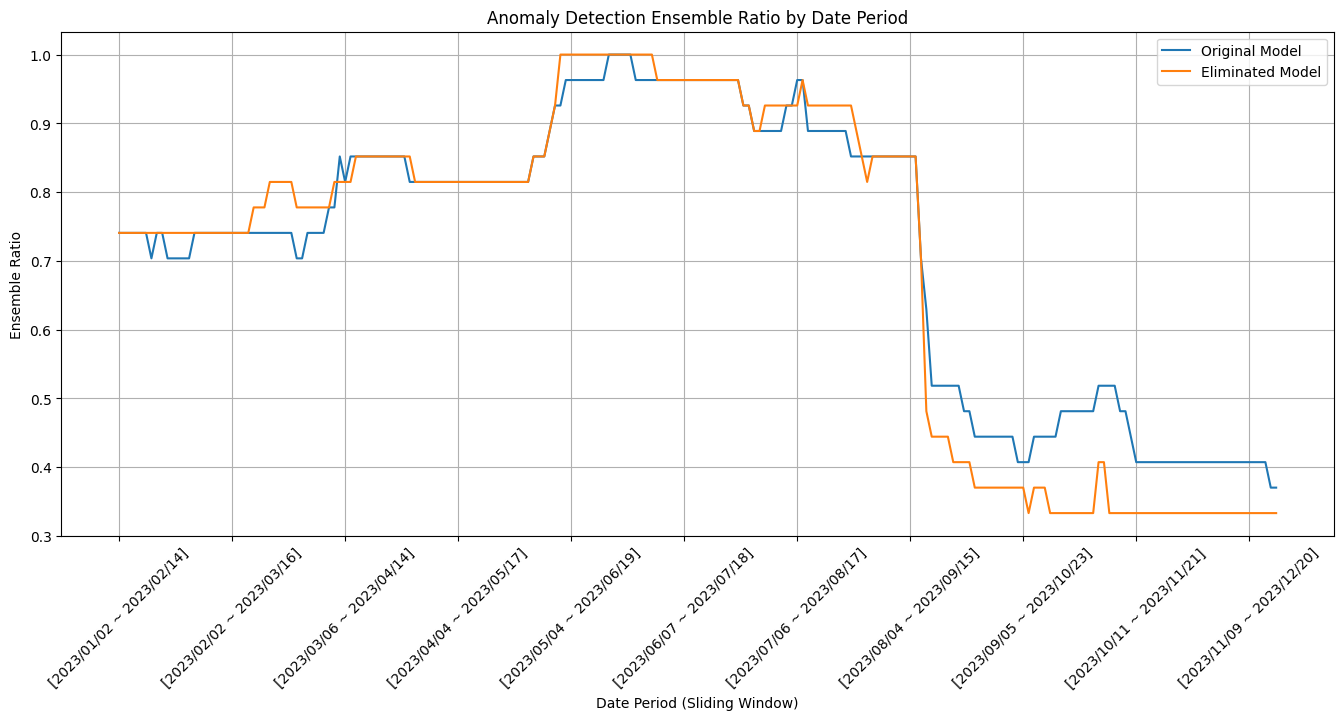

In [ ]:
plt.figure(figsize=(14, 6))
for label, ratios in ensemble_ratios.items():
    plt.plot(date_ranges, ratios, label=label)

plt.xlabel("Date Period (Sliding Window)")
plt.ylabel("Ensemble Ratio")
plt.title("Anomaly Detection Ensemble Ratio by Date Period")
plt.legend()
plt.grid(True)
plt.tight_layout()

# x축 라벨이 많을 때 일부만 표시 (예: 10개만)
step = max(1, len(date_ranges)//10)
plt.xticks(
    ticks=range(0, len(date_ranges), step),
    labels=[date_ranges[i] for i in range(0, len(date_ranges), step)],
    rotation=45
)

plt.show()
